## Sentinel-3 L1 SLSTR Channel 8 Brightness Temperature via Sentinel-Hub Process API

### _Import functional dependencies and add repository source directory to system path_

In [1]:
import os
import yaml
from munch import munchify

In [2]:
# define repo name and get root working directory
repo = 'process'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\apis\\process'

In [3]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'sentinel-3' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\apis\\process\\cfg\\sentinel-3'

### _Load configuration file from repository cfg sub-directory_ 

In [4]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 's3-timeseries-slstr-bt8.yml' )

In [5]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |
                //VERSION=3
                function setup() {
                    return {
                        input: [ "S8" ],
                        output: {
                            bands: 1,
                            sampleType: SampleType.UINT16
                        }
                    };
                }
                function evaluatePixel(sample) {
                    return [ sample.S8 - 273 ]
                }                       
    inputs:
        - collection: SENTINEL3_SLSTR
responses:
    default: TIFF
aoi:
    pathname: <pathname_to_aoi_file>
    field: name
    distance: 500



In [6]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

### _Define area of interest collocated with United Kingdom_

In [7]:
# define min and max latlons - see http://bboxfinder.com/
coords = -12.208014,49.473833,2.865228,59.382463
resolution = 500

In [8]:
# create instance of shclient class
from processapi import Client
client = Client( config, base_url = 'https://creodias.sentinel-hub.com' )

In [9]:
# get utm bbox - UK national grid
bbox = client.getBoundingBox( coords, dst_crs=27700 )
print ( bbox, bbox.crs.value )

-338837.2450787062,2945.7998234003317,676225.5868762305,1065184.9946709173 27700


In [10]:
# get aoi image dimensions
client.getBoxDimensions( bbox, resolution )

(1999, 2153)

### _Search for S3 SLSTR daytime scenes acquired over UK during early June 2021_

In [11]:
# imports
from datetime import datetime
from datetime import timedelta

# start of may 2021
dt = datetime( 2021, 6, 1, 0, 0, 0 )
timeframe = { 'start' : dt, 'end' : dt + timedelta(hours=48) } 
timestamps = client.getDatasetTimeStamps( config.request.inputs[ 0 ], bbox, timeframe )

timestamps

[datetime.datetime(2021, 6, 1, 10, 2, 44, 395000, tzinfo=tzutc()),
 datetime.datetime(2021, 6, 1, 11, 4, 17, 950000, tzinfo=tzutc()),
 datetime.datetime(2021, 6, 1, 20, 49, 13, 477000, tzinfo=tzutc()),
 datetime.datetime(2021, 6, 1, 22, 30, 12, 646000, tzinfo=tzutc()),
 datetime.datetime(2021, 6, 2, 9, 36, 33, 612000, tzinfo=tzutc()),
 datetime.datetime(2021, 6, 2, 10, 38, 7, 269000, tzinfo=tzutc()),
 datetime.datetime(2021, 6, 2, 12, 16, 6, 435000, tzinfo=tzutc()),
 datetime.datetime(2021, 6, 2, 20, 26, 2, 770000, tzinfo=tzutc()),
 datetime.datetime(2021, 6, 2, 22, 4, 1, 956000, tzinfo=tzutc())]

In [12]:
# get timestamps morning passes
day_timestamps = []
for timestamp in timestamps:
    if timestamp.hour >= 6 and timestamp.hour < 18:
        day_timestamps.append( timestamp ) 

day_timestamps

[datetime.datetime(2021, 6, 1, 10, 2, 44, 395000, tzinfo=tzutc()),
 datetime.datetime(2021, 6, 1, 11, 4, 17, 950000, tzinfo=tzutc()),
 datetime.datetime(2021, 6, 2, 9, 36, 33, 612000, tzinfo=tzutc()),
 datetime.datetime(2021, 6, 2, 10, 38, 7, 269000, tzinfo=tzutc()),
 datetime.datetime(2021, 6, 2, 12, 16, 6, 435000, tzinfo=tzutc())]

### _Download and visualise time series of S3 SLSTR channel 8 images using Process API client_

In [13]:
# get mosaics between timeframes
response = client.getTimeSeries ( bbox, timeframe, resolution, timestamps=day_timestamps )
response._df

default  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [[8, 8, 8, 8, 8, 7, 7, 8, 8, 8, 8, 8, 9, 9, 8,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                              time  
0 2021-06-01 10:02:44.395000+00:00  
1 2021-06-01 11:04:17.950000+00:00  
2 2021-06-02 09:36:33.612000+00:00  
3 2021-06-02 10:38:07.269000+00:00  
4 2021-06-02 12:16:06.435000+00:00

In [14]:
# mask no data values
import numpy as np
import numpy.ma as ma

response._df[ 'mask-temperature'] = response._df[ 'default' ].apply( lambda x: np.ma.masked_where( x == 0, x ) )

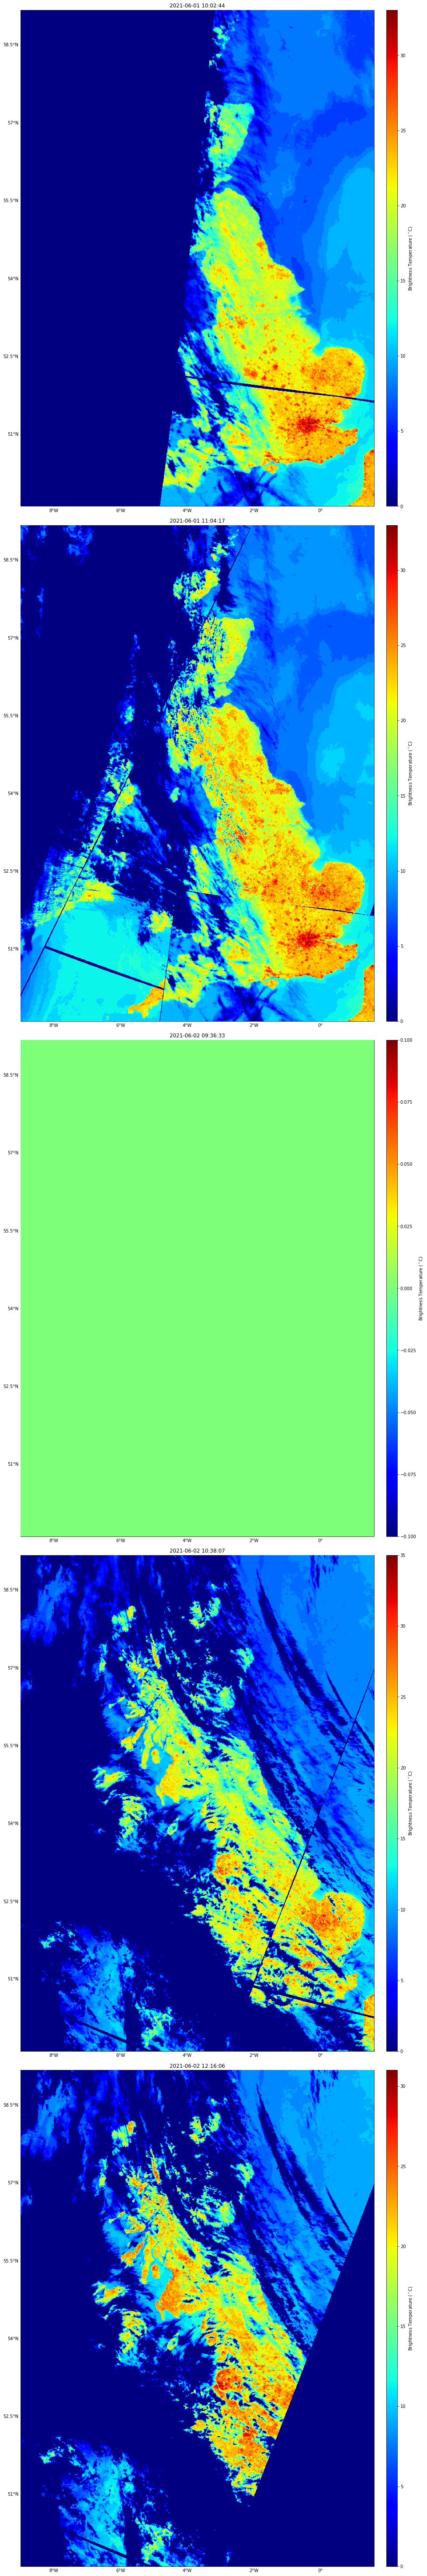

In [15]:
# plot time series images
response.plotColorMesh( 'default', alpha={ 'data' : 1.0, 'grid' : 0.0 }, cbar_label='Brightness Temperature ($^\circ$C)' )

C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


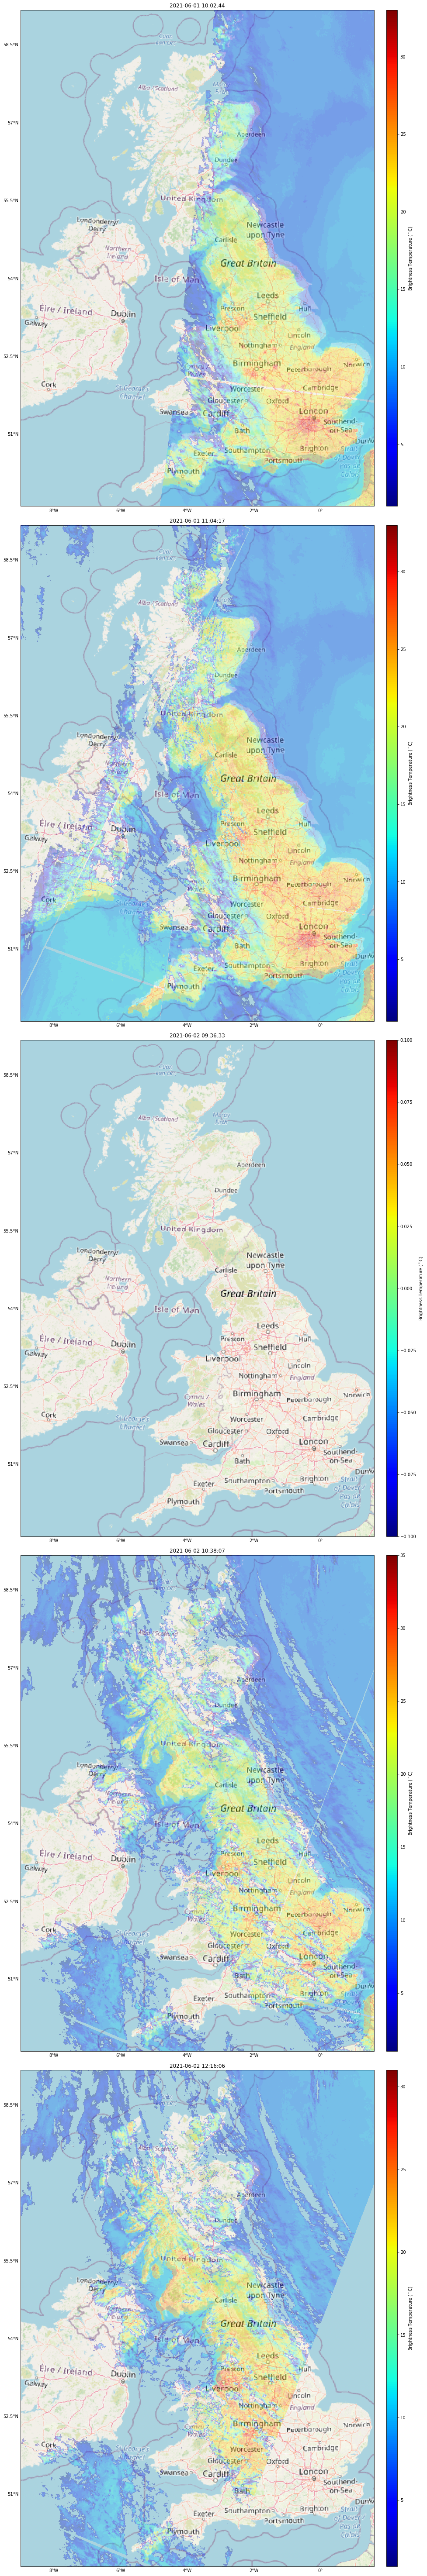

In [16]:
# plot time series images
response.plotColorMesh( 'mask-temperature', osm_zoom=6, alpha={ 'data' : 0.3, 'grid' : 0.0 }, cbar_label='Brightness Temperature ($^\circ$C)' )